# Battle Royale Survival Rate
## Math concepts for developers final project
**Author: Viktor Georgiev**  
**Date: May 2025**

### Introduction
Let us face it — everybody has at least once in their life played a game like PUBG, Fortnite, Call of Duty Warzone / Mobile, or something similar. 
In recent times, TV series like *Squid Game* and *Alice in Borderland* have further popularized the idea, which possibly started with the *Hunger Games* book series.

This project simulates a simplified Battle Royale scenario and uses **probability theory**, **stochastic simulation**, and **statistical analysis** to estimate each player’s survival chances. 
The results help answer questions like:

- How does initial skill influence survival?
- How many rounds are typically needed until only one survives?

---

### Project goals
- Model a **simplified Battle Royale** with `N` players.
- Implement **random encounters** between players, with probabilistic outcomes based on skill.
- Use **Monte Carlo simulation** to estimate survival rates.
- Apply **probability**, **combinatorics**, and **basic Markov modeling** to understand outcomes.
- Visualize key results using graphs and plots.
- Explore potential **strategic insights** based on survival analysis.

### Methodology overview
- Define a set of players, each with a skill rating.
- Determine outcome of each encounter using **probabilistic rules**.
- Repeat the process until only one player remains.
- Run thousands of simulations to gather statistics.
- Analyze results using probability theory and visualization.

---

### Tools and Concepts
- Probability and Conditional Probability
- Random Variables and Expected Value
- Monte Carlo Simulation
- Markov Chains (absorbing state modeling)
- Statistical Visualization

---

In [ ]:
# Imports
import random
import math
import matplotlib.pyplot as plt
import numpy as np

## General rules of the simulator and maths

### 1. Player Attributes: Gender, Age and Background

- Gender: This could affect the base skill (e.g., male players could have a higher average skill based on physicality in combat, while female players may have a different strategy).
- Age: The skill of a player decreases with age, especially above 50. This could be represented as a function where the skill **S** decreases as age **A** increases
$$S_{age}(A) = S_{base} * (1 - 0.05 * max(0, A - 50))$$

This formula represents a 5% decrease in skill for every year above 50. For ages below 50, the skill remains the same.

- Backgrounds: Different backgrounds provide different advantages, such as:
    * Programmer: Better at strategy, with higher chance of survival when hiding or avoiding conflict.
    * MMA Fighter: Higher combat skill, but lower strategy or survival when hiding.
    * Soldier: Balanced in combat and survival.
    * Doctor: Can heal or reduce injuries, improving survival chances.
    * Construction worker: Can use equipment better
    * Others

We can model these advantages by adding background multipliers to the base skill:
$$
S_{\text{background}} = S_{\text{base}} \times M_{\text{background}}
$$

where $M_{background}$ is a multiplier based on the background (e.g. MMA fighter $M_{MMA}$ = 1.2, Doctor $M_{doctor}$ = 1.1)

---


### 2. Strategies

Players can adopt different strategies during the game, which affect their survival probability. We can represent this as a conditional probability:

- **Aggressive strategy**:  Higher risk of death but higher chance of eliminating opponents.
- **Hiding strategy**: Lower risk of death, but lower chance of eliminating opponents.
- **Balanced strategy**: Mix of both

We can use a strategy modifier $M_{strategy}$ that adjusts the survival probability based on the strategy:

$$P_{survival}(strategy) = P_{base} * M_{strategy}$$

where $M_{strategy}$ could take values based on the strategy chosen (e.g., for aggressive: $M_{aggressive}$ = 0.8, hiding $M_{hiding}$ = 0.8)


---

### 3. Injuries and Sickness

Injuries or sickness can decrease a player's survival probability. Let’s define a probability reduction factor $R_{injury}$ or $R_{sickness}$ based on the severity of the condition:

$$P_{survival} = P_{base} * (1 - R_{injury}) * (1 - R_{sickness})$$

where:

$R_{injury}$ and $R_{sickness}$ are factors between 0 and 1, where 1 represents a fatal injury or sickness.

---

### 4. Team Dynamics

When players with similar backgrounds team up, they can boost each other’s survival chances. This can be modeled using a cooperative multiplier $M_{team}$

$$P_{survival | team} = P_{base} * M_{team}$$

where $M_{team}$ > 1 (e.g. $M_{team}$ = 1.2) if the players have compatible backgrounds (e.g., two soldiers teaming up).

---

### 5. Zone shrinking
The shrinking game zone could be modeled as a deterministic function where players outside the zone die or suffer a survival penalty. If the player is outside the zone, their survival probability becomes 0, otherwise:

\[
$P_{survival|zone}$ = 
\begin{cases}
0, & \text{if player is outside the zone} \\
P_{\text{base}}, & \text{if player is inside the zone}
\end{cases}
\]


The shrinking zone itself can be modeled with a time-dependent radius $r(t)$ where $r$ decreases as time progresses:

$$r(t) = r_{0} - k * t$$

where $r_{0}$ is the initial radius and $k$ is the shrink rate

--- 

### 6. Weapons and Items

Weapons found during the game can boost the player's skill or alter the outcome of encounters. We can model the weapon effect as a multiplier:

$$S_{weapon} = S_{base} * M_{weapon}$$

where $M_{weapon}$ is  is a multiplier based on the type of weapon (e.g., a gun might have $M_{weapon}$ = 1.5)


---

### 7.Overall Survival Probability

Combining all factors we get this formula:

$$P_{survival} = P_{base} * M_{age} * M_{background} * M_{strategy} * (1 - R_{injury}) * (1 - R_{sickness}) * M_{team} * M_{weapon} * P_{zone}$$

This formula accounts for all the factors affecting a player’s survival.

---

### 8. Bayesian Inference for Dynamic Updates

- **Context**: As the game progresses, new information (such as injuries, encounters, weapons found) becomes available. We can use **Bayesian Inference** to update the survival probabilities dynamically as new data comes in.
- **How to use it**:
    * Each player has a prior survival probability $P\frac{prior}{survival}$ based on their initial conditions (e.g., age, gender, background).
    * As the game progresses, new observations (such as successful encounters or injuries) can be used to update the survival probability using Bayes’ Theorem:

$$P_{survival|data} = \frac{P_{(data|survival)} * P_{survival}}{P_{data}}$$

This allows the simulation to adjust each player's survival probability as they encounter new challenges or make progress through the game.

---


In [ ]:
# Player attributes
# Player class
class Player:
    def __init__(self, name, gender, age, background):
        self.name = name
        self.gender = gender.lower()
        self.age = age
        self.background = background.lower()

        self.base_skill = 1.0

        # Gender modifier
        gender_multipliers = {
            'male': 1.0,
            'female': 0.95
        }
        self.M_gender = gender_multipliers.get(self.gender, 1.0)  # Default to 1.0 if unknown

        # Age penalty: -5% per year over 50
        if self.age > 50:
            self.M_age = 1 - 0.05 * (self.age - 50)
        else:
            self.M_age = 1.0

        # Background multiplier
        background_multipliers = {
            'programmer': 0.9,
            'mma_fighter': 1.2,
            'soldier': 1.1,
            'doctor': 1.1,
            'construction_worker': 1.0,
            'other': 1.0
        }
        self.M_background = background_multipliers.get(self.background, 1.0)

        # Total skill modifier
        self.skill = self.base_skill * self.M_gender * self.M_age * self.M_background

    def __repr__(self):
        return f"{self.name} | Gender: {self.gender} | Age: {self.age} | Background: {self.background} | Skill: {self.skill:.2f}"

        

In [ ]:
# Let us check if the age penalty and background multiplier and gender multiplier are working as expected

for age in range(45, 61, 3):
    p = Player("Test", "male", age, "soldier")
    print(f"Age {age} => Skill: {p.skill:.2f}")
    
backgrounds = ['programmer', 'mma_fighter', 'soldier', 'doctor', 'construction_worker', 'other']
for bg in backgrounds:
    p = Player("Test", "male", 30, bg)
    print(f"Background: {bg} => Skill: {p.skill:.2f}")
    


This clearly shows that the logic is working

In [ ]:
# --- Plot for Age vs Skill ---
ages = range(45, 61, 3)
age_skills = [Player("Test", "male", age, "soldier").skill for age in ages]

# Plot Age vs Skill
plt.figure(figsize=(10, 6))
plt.plot(ages, age_skills, marker='o', linestyle='-', color='b', label='Soldier')

plt.title("Survival Skill vs Age", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Survival Skill", fontsize=12)
plt.grid(True)
plt.xticks(ages)
plt.legend()
plt.show()

# --- Plot for Background vs Skill ---
backgrounds = ['programmer', 'mma_fighter', 'soldier', 'doctor', 'construction_worker', 'other']
bg_skills = [Player("Test", "male", 30, bg).skill for bg in backgrounds]

# Plot Background vs Skill
plt.figure(figsize=(10, 6))
plt.bar(backgrounds, bg_skills, color=['blue', 'orange', 'green', 'red', 'purple', 'gray'])

plt.title("Survival Skill vs Background", fontsize=16)
plt.xlabel("Background", fontsize=12)
plt.ylabel("Survival Skill", fontsize=12)
plt.grid(True, axis='y')
plt.show()

In [ ]:
# Let us add strategy to the class and check if it is working as expected

class Player:
    def __init__(self, name, gender, age, background, strategy):
        self.name = name
        self.gender = gender.lower()
        self.age = age
        self.background = background.lower()
        self.strategy = strategy.lower()

        self.base_skill = 1.0

        # Gender multiplier
        gender_multipliers = {
            'male': 1.0,
            'female': 0.95
        }
        self.M_gender = gender_multipliers.get(self.gender, 1.0)

        # Age multiplier
        self.M_age = 1 - 0.05 * max(0, self.age - 50)

        # Background multiplier
        background_multipliers = {
            'programmer': 0.9,
            'mma_fighter': 1.2,
            'soldier': 1.1,
            'doctor': 1.1,
            'construction_worker': 1.0,
            'other': 1.0
        }
        self.M_background = background_multipliers.get(self.background, 1.0)

        # Strategy multiplier
        strategy_multipliers = {
            'aggressive': 0.8,
            'hiding': 0.8,
            'balanced': 1.0
        }
        self.M_strategy = strategy_multipliers.get(self.strategy, 1.0)

        # Final skill/survival multiplier
        self.skill = (
            self.base_skill
            * self.M_gender
            * self.M_age
            * self.M_background
            * self.M_strategy
        )

    def __repr__(self):
        return (f"{self.name} | Gender: {self.gender} | Age: {self.age} | "
                f"Background: {self.background} | Strategy: {self.strategy} | "
                f"Skill: {self.skill:.2f}")


In [ ]:
p1 = Player("Alex", "male", 28, "soldier", "aggressive")
p2 = Player("Sophie", "female", 34, "doctor", "hiding")
p3 = Player("Jake", "male", 51, "mma_fighter", "balanced")

print(p1)
print(p2)
print(p3)

There is a difference in the overall skill, so it looks like it is working as expected

In [ ]:
# Redefine the class by adding injury methods and sickness methods

class Player:
    def __init__(self, name, gender, age, background, strategy):
        self.name = name
        self.gender = gender.lower()
        self.age = age
        self.background = background.lower()
        self.strategy = strategy.lower()

        self.base_skill = 1.0
        self.injury_severity = 0.0  # R_injury
        self.sickness_severity = 0.0  # R_sickness

        # Gender multiplier
        gender_multipliers = {
            'male': 1.0,
            'female': 0.95
        }
        self.M_gender = gender_multipliers.get(self.gender, 1.0)

        # Age multiplier
        self.M_age = 1 - 0.05 * max(0, self.age - 50)

        # Background multiplier
        background_multipliers = {
            'programmer': 0.9,
            'mma_fighter': 1.2,
            'soldier': 1.1,
            'doctor': 1.1,
            'construction_worker': 1.0,
            'other': 1.0
        }
        self.M_background = background_multipliers.get(self.background, 1.0)

        # Strategy multiplier
        strategy_multipliers = {
            'aggressive': 0.8,
            'hiding': 0.8,
            'balanced': 1.0
        }
        self.M_strategy = strategy_multipliers.get(self.strategy, 1.0)

        # Final base survival multiplier (before dynamic updates)
        self.base_survival = (
            self.base_skill
            * self.M_gender
            * self.M_age
            * self.M_background
            * self.M_strategy
        )

    def apply_injury(self, severity):
        """Severity: 0 (none) to 1 (fatal)."""
        self.injury_severity = min(max(severity, 0), 1)

    def apply_sickness(self, severity):
        """Severity: 0 (none) to 1 (fatal)."""
        self.sickness_severity = min(max(severity, 0), 1)

    def get_survival_probability(self):
        survival = self.base_survival * (1 - self.injury_severity) * (1 - self.sickness_severity)
        return round(survival, 4)

    def __repr__(self):
        return (f"{self.name} | Skill: {self.base_survival:.2f} | "
                f"Injury: {self.injury_severity:.2f} | Sickness: {self.sickness_severity:.2f} | "
                f"Survival P: {self.get_survival_probability():.4f}")


In [ ]:
p1 = Player("Sam", "male", 40, "soldier", "aggressive")
print(p1)
p1.apply_injury(0.3)
print(p1)
p1.apply_sickness(0.2)
print(p1)

In [ ]:
injury_severities = np.linspace(0, 1, 100)
p1 = Player("Sam", "male", 40, "soldier", "aggressive")
injury_survival = [p1.apply_injury(severity) or p1.get_survival_probability() for severity in injury_severities]

# --- Plot Sickness vs Survival ---
sickness_severities = np.linspace(0, 1, 100)
sickness_survival = [p1.apply_sickness(severity) or p1.get_survival_probability() for severity in sickness_severities]

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot for Injury Severity vs Survival Probability
plt.subplot(1, 2, 1)
plt.plot(injury_severities, injury_survival, color='r', label="Injury Impact")
plt.title("Survival Probability vs Injury Severity")
plt.xlabel("Injury Severity")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()

# Plot for Sickness Severity vs Survival Probability
plt.subplot(1, 2, 2)
plt.plot(sickness_severities, sickness_survival, color='b', label="Sickness Impact")
plt.title("Survival Probability vs Sickness Severity")
plt.xlabel("Sickness Severity")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**By running the code above, we can see that the player has a different survival P after injury and/or sickness** 

In [ ]:
# Continue with teams
# Add teams to the player class and check whether injury/sickness is fatal and add weapons

class Player:
    def __init__(self, name, age, gender, background, strategy, injury_severity=0.0, sickness_severity=0.0, has_weapon=False, teammates=None):
        self.name = name
        self.age = age
        self.gender = gender  # "male" or "female"
        self.background = background  # e.g., "programmer", "soldier"
        self.strategy = strategy  # "aggressive", "hiding", "balanced"
        self.injury_severity = injury_severity  # between 0 and 1
        self.sickness_severity = sickness_severity  # between 0 and 1
        self.has_weapon = has_weapon
        self.teammates = teammates or []
        self.is_alive = True

        # Base skill and multipliers
        self.base_survival = 1.0
        self.age_multiplier = self.get_age_multiplier()
        self.background_multiplier = self.get_background_multiplier()
        self.strategy_multiplier = self.get_strategy_multiplier()
        self.weapon_multiplier = 1.5 if has_weapon else 1.0
        self.gender_multiplier = self.get_gender_multiplier()

    def get_age_multiplier(self):
        return max(0.0, 1 - 0.05 * max(0, self.age - 50))

    def get_background_multiplier(self):
        background_multipliers = {
            "programmer": 1.1,
            "mma_fighter": 1.2,
            "soldier": 1.15,
            "doctor": 1.1,
            "construction_worker": 1.1,
            "default": 1.0
        }
        return background_multipliers.get(self.background.lower(), background_multipliers["default"])

    def get_strategy_multiplier(self):
        strategy_multipliers = {
            "aggressive": 0.8,
            "hiding": 0.8,
            "balanced": 1.0
        }
        return strategy_multipliers.get(self.strategy.lower(), 1.0)

    def get_gender_multiplier(self):
        # Optional: you can define gender-specific multipliers
        # For now, both are neutral
        gender_multipliers = {
            "male": 1.0,
            "female": 1.0
        }
        return gender_multipliers.get(self.gender.lower(), 1.0)

    def get_team_multiplier(self):
        if not self.teammates:
            return 1.0
        compatible_backgrounds = [teammate.background == self.background for teammate in self.teammates]
        return 1.2 if any(compatible_backgrounds) else 1.0

    def get_survival_probability(self):
        M_team = self.get_team_multiplier()
        survival = (
            self.base_survival
            * self.age_multiplier
            * self.background_multiplier
            * self.strategy_multiplier
            * self.weapon_multiplier
            * self.gender_multiplier
            * (1 - self.injury_severity)
            * (1 - self.sickness_severity)
            * M_team
        )
        survival = round(survival, 4)
        self.is_alive = survival > 0
        return survival


**Let us check how things are looking so far**

In [ ]:
# base survival
p1 = Player(name="Test1", age=30, gender="male", background="soldier", strategy="balanced")
print(f"Base survival: {p1.get_survival_probability()}")  # Expect around 1.15 (since soldier has 1.15 multiplier)

# Age over 50
p2 = Player(name="OldMan", age=60, gender="male", background="soldier", strategy="balanced")
print(f"Age over 50: {p2.get_survival_probability()}")  # Expect significant reduction due to age

# Injury over 1 (fatal)
p3 = Player(name="Injured", age=30, gender="female", background="doctor", strategy="hiding", injury_severity=1.0)
print(f"Injury: {p3.get_survival_probability()}")  # Should be 0.0
print(f"Is alive: {p3.is_alive}")  # Should be False

# Weapon effect
p4 = Player(name="Armed", age=25, gender="female", background="programmer", strategy="aggressive", has_weapon=True)
print(f"Survival with weapon: {p4.get_survival_probability()}")  # Should be increased by 1.5x multiplier

# Team bonus
teammate = Player(name="Buddy", age=30, gender="male", background="soldier", strategy="balanced")
p5 = Player(name="TeamPlayer", age=30, gender="male", background="soldier", strategy="balanced", teammates=[teammate])
print(f"Survival with team: {p5.get_survival_probability()}")  # Should include team multiplier (1.2)

# Edge case (should be 0)
p6 = Player(name="DeadMan", age=80, gender="male", background="doctor", strategy="balanced", injury_severity=1.0, sickness_severity=1.0)
print(f"Should be dead (Result must be 0): {p6.get_survival_probability()}")  # Should be 0.0
print(f"Is alive: {p6.is_alive}")  # Should be False

**Results look good**

In [ ]:
# Continue with zone shrinking
# Define zone class
class Zone:
    def __init__(self):
        self.radius = 100  # Initial radius of the zone
        self.center_x = 0 # X-coordinate of the center of the zone
        self.center_y = 0  # Y-coordinate of the center of the zone
        self.shrink_rate = 10  # How fast the zone shrinks per round

    def shrink(self):
        """Shrinks the zone by the shrink_rate each round."""
        self.radius -= self.shrink_rate
        if self.radius < 5:
            self.radius = 5  # Ensure the radius doesn't go below a small enough space for players to fight in

    def is_inside(self, player_x, player_y):
        """Checks if the player is inside the current zone."""
        distance = math.sqrt((self.center_x - player_x) ** 2 + (self.center_y - player_y) ** 2)
        return distance <= self.radius


In [ ]:


class Player:
    def __init__(self, name, age, gender, background, strategy, injury_severity=0.0, sickness_severity=0.0, has_weapon=False, teammates=None):
        self.name = name
        self.age = age
        self.gender = gender  # "male" or "female"
        self.background = background  # e.g., "programmer", "soldier"
        self.strategy = strategy  # "aggressive", "hiding", "balanced"
        self.injury_severity = injury_severity  # between 0 and 1
        self.sickness_severity = sickness_severity  # between 0 and 1
        self.has_weapon = has_weapon
        self.teammates = teammates or []
        self.is_alive = True
        
        angle = random.uniform(0, 2 * math.pi)
        radius = random.uniform(0, 100)
        self.x = radius * math.cos(angle)
        self.y = radius * math.sin(angle)

        # Base skill and multipliers
        self.base_survival = 1.0
        self.age_multiplier = self.get_age_multiplier()
        self.background_multiplier = self.get_background_multiplier()
        self.strategy_multiplier = self.get_strategy_multiplier()
        self.weapon_multiplier = 1.5 if has_weapon else 1.0
        self.gender_multiplier = self.get_gender_multiplier()

    def get_age_multiplier(self):
        return max(0.0, 1 - 0.05 * max(0, self.age - 50))

    def get_background_multiplier(self):
        background_multipliers = {
            "programmer": 1.1,
            "mma_fighter": 1.2,
            "soldier": 1.15,
            "doctor": 1.1,
            "construction_worker": 1.1,
            "default": 1.0
        }
        return background_multipliers.get(self.background.lower(), background_multipliers["default"])

    def get_strategy_multiplier(self):
        strategy_multipliers = {
            "aggressive": 0.8,
            "hiding": 0.8,
            "balanced": 1.0
        }
        return strategy_multipliers.get(self.strategy.lower(), 1.0)

    def get_gender_multiplier(self):
        # Optional: you can define gender-specific multipliers
        # For now, both are neutral
        gender_multipliers = {
            "male": 1.0,
            "female": 1.0
        }
        return gender_multipliers.get(self.gender.lower(), 1.0)

    def get_team_multiplier(self):
        if not self.teammates:
            return 1.0
        compatible_backgrounds = [teammate.background == self.background for teammate in self.teammates]
        return 1.2 if any(compatible_backgrounds) else 1.0

    def get_survival_probability(self, zone):
        if not self.is_alive:
            return 0.0

        if not self.is_inside_zone(zone):
            self.is_alive = False
            return 0.0

        M_team = self.get_team_multiplier()
        survival = (
            self.base_survival
            * self.age_multiplier
            * self.background_multiplier
            * self.strategy_multiplier
            * self.weapon_multiplier
            * self.gender_multiplier
            * (1 - self.injury_severity)
            * (1 - self.sickness_severity)
            * M_team
        )
        survival = round(min(survival, 1.0), 4)
        self.is_alive = survival > 0
        return survival
    
    def move(self):
        """Moves the player to a new random position (simulating repositioning)."""
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, 10)  # Max 10 units move per round
        self.x += distance * math.cos(angle)
        self.y += distance * math.sin(angle)
        
    def is_inside_zone(self, zone):
        """Checks if the player is inside the current zone."""
        distance = math.sqrt((zone.center_x - self.x) ** 2 + (zone.center_y - self.y) ** 2)
        return distance <= zone.radius
    
    def update_status(self):
        """Randomly apply damage, illness, or find weapon."""
        if random.random() < 0.2:
            self.injury_severity += random.uniform(0.05, 0.2)
        if random.random() < 0.1:
            self.sickness_severity += random.uniform(0.05, 0.2)
        if not self.has_weapon and random.random() < 0.15:
            self.has_weapon = True
            self.weapon_multiplier = 1.5

        # Clamp values
        self.injury_severity = min(self.injury_severity, 1.0)
        self.sickness_severity = min(self.sickness_severity, 1.0)
        


In [ ]:
# Define function to create random players
def generate_random_players(num_players):
    names = [f"Player{i+1}" for i in range(num_players)]
    genders = ["male", "female"]
    backgrounds = ["programmer", "mma_fighter", "soldier", "doctor", "construction_worker"]
    strategies = ["aggressive", "hiding", "balanced"]

    players = []

    for name in names:
        age = random.randint(18, 65)
        gender = random.choice(genders)
        background = random.choice(backgrounds)
        strategy = random.choice(strategies)
        injury_severity = round(random.uniform(0.0, 0.3), 2)
        sickness_severity = round(random.uniform(0.0, 0.2), 2)
        has_weapon = random.random() < 0.3  # 30% chance to start with a weapon

        player = Player(
            name=name,
            age=age,
            gender=gender,
            background=background,
            strategy=strategy,
            injury_severity=injury_severity,
            sickness_severity=sickness_severity,
            has_weapon=has_weapon
        )
        players.append(player)

    return players

In [ ]:

# Example usage: Run a simulation with all the logic so far

# -----------------------
# Run simulation
# -----------------------
# Plotting function
def plot_players(players, round_num, zone):
    """Plot the players' positions and survival probabilities with legend."""
    plt.figure(figsize=(8, 8))

    # Filter alive players
    alive_players = [p for p in players if p.is_alive]

    x_positions = [p.x for p in alive_players]
    y_positions = [p.y for p in alive_players]
    survival_probs = [p.get_survival_probability(zone) for p in alive_players]

    # Plot players
    scatter = plt.scatter(
        x_positions,
        y_positions,
        c=survival_probs,
        cmap='viridis',
        s=100,
        edgecolors='black',
        label='Players'
    )

    # Annotate each point with the player's name
    for player in alive_players:
        plt.annotate(player.name, (player.x, player.y), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)

    # Plot zone as a circle
    circle = plt.Circle((zone.center_x, zone.center_y), zone.radius, color='red', fill=False, linestyle='--', linewidth=2, label='Zone')
    plt.gca().add_patch(circle)

    # Colorbar and plot settings
    plt.colorbar(scatter, label="Survival Probability")
    plt.title(f"Round {round_num} - Player Positions and Survival Probability")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(-110, 110)
    plt.ylim(-110, 110)
    plt.grid(True)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


zone = Zone()
players = generate_random_players(10)

# Assign teammates with the same background (optional team logic)
for p in players:
    p.teammates = [other for other in players if other != p and other.background == p.background]

# Simulate rounds
for round_num in range(1, 6):
    print(f"\n--- Round {round_num} ---")
    zone.shrink()

    # Update player status and move players
    for p in players:
        if p.is_alive:
            p.move()
            p.update_status()
            prob = p.get_survival_probability(zone)
            # Probabilistic death check
            # Probabilistic death check
            if random.random() > prob:
                p.is_alive = False
                print(f"{player.name} has died.")
            print(f"{p.name} ({p.background}) | Pos: ({round(p.x, 1)}, {round(p.y, 1)}) | Prob: {prob} | Alive: {p.is_alive}")
    
    # Plot the players for the current round
    plot_players(players, round_num, zone)

**We can see that the zone is now correctly impacting the survival of a player. However, a player should not technically die if outsize the zone, just have a harder time surviving.Let us work with this.Another issue is that at the moment, the chance of survival is technically bigger, because you only "die" if you are outside of the zone, which does not have a big change to happen. This can be seen at the small change to the probability after each round**


In [ ]:
# update the class



class Player:
    def __init__(self, name, age, gender, background, strategy, injury_severity=0.0, sickness_severity=0.0, has_weapon=False, teammates=None):
        self.name = name
        self.age = age
        self.gender = gender  # "male" or "female"
        self.background = background  # e.g., "programmer", "soldier"
        self.strategy = strategy  # "aggressive", "hiding", "balanced"
        self.injury_severity = injury_severity  # between 0 and 1
        self.sickness_severity = sickness_severity  # between 0 and 1
        self.has_weapon = has_weapon
        self.teammates = teammates or []
        self.is_alive = True
        
        angle = random.uniform(0, 2 * math.pi)
        radius = random.uniform(0, 100)
        self.x = radius * math.cos(angle)
        self.y = radius * math.sin(angle)

        # Base skill and multipliers
        self.base_survival = 1.0
        self.age_multiplier = self.get_age_multiplier()
        self.background_multiplier = self.get_background_multiplier()
        self.strategy_multiplier = self.get_strategy_multiplier()
        self.weapon_multiplier = 1.5 if has_weapon else 1.0
        self.gender_multiplier = self.get_gender_multiplier()

    def get_age_multiplier(self):
        return max(0.0, 1 - 0.05 * max(0, self.age - 50))

    def get_background_multiplier(self):
        background_multipliers = {
            "programmer": 1.1,
            "mma_fighter": 1.2,
            "soldier": 1.15,
            "doctor": 1.1,
            "construction_worker": 1.1,
            "default": 1.0
        }
        return background_multipliers.get(self.background.lower(), background_multipliers["default"])

    def get_strategy_multiplier(self):
        strategy_multipliers = {
            "aggressive": 0.8,
            "hiding": 0.8,
            "balanced": 1.0
        }
        return strategy_multipliers.get(self.strategy.lower(), 1.0)

    def get_gender_multiplier(self):
        # Optional: you can define gender-specific multipliers
        # For now, both are neutral
        gender_multipliers = {
            "male": 1.0,
            "female": 1.0
        }
        return gender_multipliers.get(self.gender.lower(), 1.0)

    def get_team_multiplier(self):
        if not self.teammates:
            return 1.0
        compatible_backgrounds = [teammate.background == self.background for teammate in self.teammates]
        return 1.2 if any(compatible_backgrounds) else 1.0

    def get_survival_probability(self, zone):
        if not self.is_alive:
            return 0.0

        # Check if player is in the zone
        in_zone = zone.is_inside(self.x, self.y)
        zone_penalty = 0.7 if not in_zone else 1.0  # 30% penalty if outside

        M_team = self.get_team_multiplier()
        survival = (
            self.base_survival
            * self.age_multiplier
            * self.background_multiplier
            * self.strategy_multiplier
            * self.weapon_multiplier
            * self.gender_multiplier
            * (1 - self.injury_severity)
            * (1 - self.sickness_severity)
            * M_team
            * zone_penalty
        )

        survival = round(survival, 4)
        self.is_alive = survival > 0
        return survival
    
    def move(self):
        """Moves the player to a new random position (simulating repositioning)."""
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, 10)  # Max 10 units move per round
        self.x += distance * math.cos(angle)
        self.y += distance * math.sin(angle)
        
    def is_inside_zone(self, zone):
        """Checks if the player is inside the current zone."""
        distance = math.sqrt((zone.center_x - self.x) ** 2 + (zone.center_y - self.y) ** 2)
        return distance <= zone.radius
    
    def update_status(self):
        """Randomly apply damage, illness, or find weapon."""
        if random.random() < 0.2:
            self.injury_severity += random.uniform(0.05, 0.2)
        if random.random() < 0.1:
            self.sickness_severity += random.uniform(0.05, 0.2)
        if not self.has_weapon and random.random() < 0.15:
            self.has_weapon = True
            self.weapon_multiplier = 1.5

        # Clamp values
        self.injury_severity = min(self.injury_severity, 1.0)
        self.sickness_severity = min(self.sickness_severity, 1.0)
        



In [ ]:
zone = Zone()
players = generate_random_players(10)

for round_num in range(1, 6):
    print(f"\n--- Round {round_num} ---")
    zone.shrink()

    for player in players:
        if player.is_alive:
            player.move()
            player.update_status()
            prob = player.get_survival_probability(zone)
            # Probabilistic death check
            if random.random() > prob:
                player.is_alive = False
                print(f"{player.name} has died.")
            print(f"{player.name} | Pos: ({round(player.x,1)}, {round(player.y,1)}) | Survival Prob: {prob} | In Zone: {zone.is_inside(player.x, player.y)} | Has weapon: {player.has_weapon} | Is alive: {player.is_alive}")
    plot_players(players, round_num, zone)

**We can now see far better results than before. Technically, every player has a chance of survival if probability is more than 0, so I will not make a certain death due to the zone or too low chance. Now, the results correctly show a bigger difference in the survival probability when outside of the zone, but the player still has a survival chance.**

---

## Simulations with Markov Chains to determine probability over many battle royals

In [ ]:
# Monte carlos simulations function

def monte_carlo_simulations(players, zone, num_simulations = 1000):
    survival_counts = {player.name: 0 for player in players}  # Track how many times each player survives
    
    for sim in range(num_simulations):
        # Copy players to avoid modifying the original player objects
        trial_players = [Player(player.name, player.age, player.gender, player.background, player.strategy, player.injury_severity, player.sickness_severity, player.has_weapon, player.teammates) for player in players]
        for p in trial_players:
            p.is_alive = True # make all players alive at the start of each simulation
        trial_zone = Zone() # need new zone each time, otherwise the zone is too small and everyone dies
        # Simulate the game until only one player remains
        while len([player for player in trial_players if player.is_alive]) > 1:
            trial_zone.shrink()  # Shrink the zone for each round, use new zone each time

            for player in trial_players:
                if player.is_alive:
                    player.move()
                    player.update_status()
                    prob = player.get_survival_probability(zone)
                    # Probabilistic death check
                    if random.random() > prob: # generate a random number between 0 and 1 (float), survival is all up to chance that way
                        player.is_alive = False
                        
        # After the loop ends, the last remaining player is the winner
        for player in trial_players:
            if player.is_alive:
                survival_counts[player.name] += 1
                
        # Calculate the probability of survival for each player
    survival_probabilities = {name: count / num_simulations for name, count in survival_counts.items()}
    return survival_probabilities

### Example (Test)

In [ ]:
zone = Zone()
players = generate_random_players(100) # each battle royal match is with 100 people
survival_probabilities = monte_carlo_simulations(players, zone, num_simulations=1000)

# Print out survival probabilities for each player
for player_name, survival_prob in survival_probabilities.items():
    print(f"{player_name}: Survival Probability = {survival_prob:.4f}")

### Plot survival chance of players

In [50]:
def plot_survival_probabilities(survival_probabilities):
    # Sort by probability descending
    sorted_probs = dict(sorted(survival_probabilities.items(), key=lambda item: item[1], reverse=True))
    
    names = list(sorted_probs.keys())
    values = list(sorted_probs.values())

    plt.figure(figsize=(10, 8))
    plt.barh(names, values, color='skyblue')
    plt.xlabel("Survival Probability")
    plt.title("Monte Carlo Survival Probabilities per Player")
    plt.gca().invert_yaxis()  # Highest probability on top
    plt.tight_layout()
    plt.show()

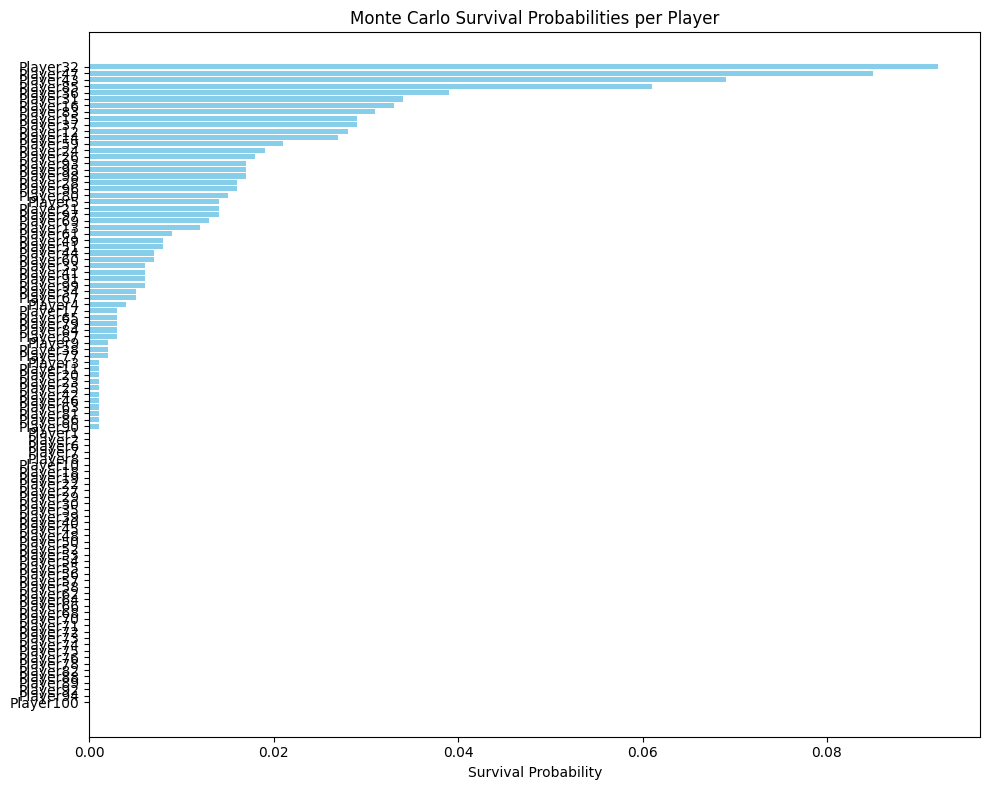

In [51]:
plot_survival_probabilities(survival_probabilities)